In [163]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.base import clone
import pandas as pd
import math

Preprocessing data

In [164]:
with open('spambase/spambase.data') as f:
    raw_data = f.readlines()

In [165]:
data_arr = np.array([row.strip('\n').split(',') for row in raw_data]).astype('float')

In [166]:
data_arr

array([[0.000e+00, 6.400e-01, 6.400e-01, ..., 6.100e+01, 2.780e+02,
        1.000e+00],
       [2.100e-01, 2.800e-01, 5.000e-01, ..., 1.010e+02, 1.028e+03,
        1.000e+00],
       [6.000e-02, 0.000e+00, 7.100e-01, ..., 4.850e+02, 2.259e+03,
        1.000e+00],
       ...,
       [3.000e-01, 0.000e+00, 3.000e-01, ..., 6.000e+00, 1.180e+02,
        0.000e+00],
       [9.600e-01, 0.000e+00, 0.000e+00, ..., 5.000e+00, 7.800e+01,
        0.000e+00],
       [0.000e+00, 0.000e+00, 6.500e-01, ..., 5.000e+00, 4.000e+01,
        0.000e+00]])

In [167]:
X = data_arr[:,:-1]
y = data_arr[:,-1]

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [169]:
scaler = StandardScaler()
scaler.fit(X)

StandardScaler()

In [170]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Problem 1

In [171]:
logistic_model = LogisticRegression(random_state=0).fit(X_train, y_train)

In [172]:
y_pred = logistic_model.predict(X_test)

In [173]:
cm = confusion_matrix(y_test, y_pred)

In [174]:
cm

array([[650,  26],
       [ 63, 412]])

In [175]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f'True Positives: {tp}\nFalse Positives: {fp}\nTrue Negatives: {tn}\nFalse Negatives: {fn}')

True Positives: 412
False Positives: 26
True Negatives: 650
False Negatives: 63


In [176]:
def four_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc = (tp + tn)/(tn+fp+fn+tp)
    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    f1 = (2 * precision * recall)/(precision + recall)
    
    return acc, precision, recall, f1

In [177]:
acc, precision, recall, f1 = four_metrics(y_test, y_pred)

In [178]:
print(f'Accuracy: {acc}\nError: {1 - acc}\nPrecision: {precision}\nRecall: {recall}\nF1 score: {f1}')

Accuracy: 0.9226759339704604
Error: 0.07732406602953956
Precision: 0.9406392694063926
Recall: 0.8673684210526316
F1 score: 0.9025191675794085


In [179]:
logistic_model.coef_

array([[-0.06998354, -0.17615277,  0.06590797,  0.82605282,  0.40643654,
         0.14796231,  0.91355967,  0.18269262,  0.1451582 ,  0.04109918,
        -0.08383017, -0.0807548 , -0.0101959 ,  0.02326336,  0.37713375,
         0.86356395,  0.40341468,  0.05638737,  0.17663286,  0.58995531,
         0.28471118,  0.23850801,  0.91523016,  0.15785938, -2.65250354,
        -0.84135558, -4.18937477,  0.19678316, -0.95534242, -0.30700541,
        -0.38232786, -0.22624911, -0.71412453, -0.01651371, -0.75033087,
         0.44693765, -0.01309982, -0.14120068, -0.38449648, -0.15384594,
        -1.58700394, -1.25142703, -0.2139786 , -1.32635266, -0.76524478,
        -1.17904533, -0.18657693, -1.05480204, -0.29247613, -0.0736021 ,
        -0.09551995,  0.2074728 ,  1.20571643,  0.90500773, -0.24051134,
         0.75504565,  0.69880815]])

In [180]:
logistic_model.intercept_

array([-2.64615871])

In [181]:
np.argmax(abs(logistic_model.coef_))

26

In [182]:
with open('spambase/spambase.names') as f:
    data_names = f.readlines()

In [183]:
feature_desc = [row.split(':')[0] for row in list(filter(lambda x: x[0] != '|', data_names))[4:]]

In [184]:
feature_desc[26]

'word_freq_george'

In [185]:
df = pd.DataFrame(columns=['Threshold', 'Accuracy', 'Precision', 'Recall'])
thresholds = [0.25, 0.5, 0.75, 0.9]
y_pred_prob = logistic_model.predict_proba(X_test)
for threshold in thresholds:
    y_pred_threshold = np.array([1 if pred[1] >= threshold else 0 for pred in y_pred_prob])
    acc, precision, recall, _ = four_metrics(y_test, y_pred_threshold)
    df_new_row = pd.DataFrame.from_records([{'Threshold': threshold, 'Accuracy':acc, 'Precision': precision, 'Recall': recall}])
    df = pd.concat([df, df_new_row], sort=False, ignore_index=True)

In [186]:
df

,Threshold,Accuracy,Precision,Recall
0,0.25,0.913119,0.851782,0.955789
1,0.50,0.922676,0.940639,0.867368
2,0.75,0.885317,0.957333,0.755789
3,0.90,0.827976,0.972696,0.600000


## Problem 2

In [187]:
def cross_entropy_loss(X, y, theta):
    loss = 0
    for sample, response in zip(X, y):
        try:
            loss_pos = response * np.log(logistic_predict(sample, theta))
            loss_neg = (1 - response) * np.log(1 - logistic_predict(sample, theta))
            loss += - (loss_pos + loss_neg)
        except:
            print(logistic_predict(sample, theta))
            print(loss_pos)
            print(loss_neg)
        
    return loss

In [188]:
def logistic_predict(x, theta):
    x_theta = np.float128(np.matmul(theta.T, x))
    logi = 1 / (1 + np.exp(-x_theta))
    
    #return np.clip(logi, 1e-9, 1 - 1e-9)
    return logi

In [189]:
def grad(theta, X, Y, num_features, num_samples):
    
    gradient = np.zeros(num_features)
    
    for training_sample, training_response in zip(X, Y):
        #save bias
        bias = gradient[0]
        
        #update params
        h_x = logistic_predict(training_sample, theta)
        gradient += (h_x - training_response) * training_sample
        
        #update bias separately
        gradient[0] = bias + (h_x - training_response)
        
    return gradient

In [190]:
def grad_descent(iterations: int, alpha: int, train_x: np.array, train_y: np.array, params: np.array) -> np.array:
    
    num_features = train_x.shape[1]
    num_samples = train_x.shape[0]
    
    for iteration in range(iterations):
        gradient = grad(params, train_x, train_y, num_features, num_samples)
        update = -alpha * gradient
        params += update
    
    return params

In [191]:
X_train_bias = np.insert(X_train, 0, 1, axis=1)
X_test_bias = np.insert(X_test, 0, 1, axis=1)

In [192]:
lrs = [0.01, 0.05, 0.1, 0.2]

for alpha in lrs:
    
    print(f'Alpha: {alpha}')
        
    #training 
    num_features = X_train_bias.shape[1]
    params = np.zeros(num_features)
    
    params_10 = grad_descent(10, alpha, X_train_bias, y_train, params)
    train_y_pred_prob = np.array([logistic_predict(x, params_10) for x in X_train_bias])
    train_y_pred = np.array([1 if pred >= 0.5 else 0 for pred in train_y_pred_prob])
    loss_10 = log_loss(y_train, train_y_pred)
    
    print(f'Iteration: 10, Cross Entropy Loss: {loss_10}')
    
    params_50 = grad_descent(40, alpha, X_train_bias, y_train, params_10)
    train_y_pred_prob = np.array([logistic_predict(x, params_50) for x in X_train_bias])
    train_y_pred = np.array([1 if pred >= 0.5 else 0 for pred in train_y_pred_prob])
    loss_50 = log_loss(y_train, train_y_pred)
    
    print(f'Iteration: 50, Cross Entropy Loss: {loss_50}')

    
    params_100 = grad_descent(50, alpha, X_train_bias, y_train, params_50)
    train_y_pred_prob = np.array([logistic_predict(x, params_100) for x in X_train_bias])
    train_y_pred = np.array([1 if pred >= 0.5 else 0 for pred in train_y_pred_prob])
    loss_100 = log_loss(y_train, train_y_pred)
    
    print(f'Iteration: 100, Cross Entropy Loss: {loss_100}')

    acc, precision, recall, f1 = four_metrics(y_train, train_y_pred)
    print(f'Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}\n')


Alpha: 0.01
Iteration: 10, Cross Entropy Loss: 3.2036513482217233
Iteration: 50, Cross Entropy Loss: 3.9545174900655846
Iteration: 100, Cross Entropy Loss: 3.8443910739748084
Accuracy: 0.888695652173913, Precision: 0.797752808988764, Recall: 0.9551569506726457, F1 Score: 0.8693877551020408

Alpha: 0.05
Iteration: 10, Cross Entropy Loss: 3.634149713095382
Iteration: 50, Cross Entropy Loss: 5.105837385112395
Iteration: 100, Cross Entropy Loss: 3.59410151021316
Accuracy: 0.8959420289855072, Precision: 0.815196394075982, Recall: 0.9461883408071748, F1 Score: 0.8758215150466967

Alpha: 0.1
Iteration: 10, Cross Entropy Loss: 3.664182272862797
Iteration: 50, Cross Entropy Loss: 3.654170338025927
Iteration: 100, Cross Entropy Loss: 4.985701583625828
Accuracy: 0.8556521739130435, Precision: 0.7413793103448276, Recall: 0.9641255605381166, F1 Score: 0.838206627680312

Alpha: 0.2
Iteration: 10, Cross Entropy Loss: 3.594100583143676
Iteration: 50, Cross Entropy Loss: 3.0134340887834083
Iteration: 1

In [193]:
y_pred = logistic_model.predict(X_train)
acc, precision, recall, f1 = four_metrics(y_train, y_pred)
print(f'Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}\n')

Accuracy: 0.9257971014492754, Precision: 0.9239811912225705, Recall: 0.8811659192825112, F1 Score: 0.9020657995409334



## Problem 3

In [194]:
lda_model = LinearDiscriminantAnalysis().fit(X_train, y_train)

In [195]:
kf = KFold(n_splits=10)

In [196]:
k_vals = [1, 3, 5, 20, 50]
df = pd.DataFrame(columns=['k', 'accuracy', 'error', 'precision', 'recall'])

for k in k_vals:
    accs = np.array([])
    errors = np.array([])
    precisions = np.array([])
    recalls = np.array([])

    for train_index, test_index in kf.split(X_train):

        #fit KNN with folds
        neigh = KNeighborsClassifier(n_neighbors=k)
        X_train_fold = np.array([X_train[i] for i in train_index])
        y_train_fold = np.array([y_train[i] for i in train_index])
        neigh.fit(X_train_fold, y_train_fold)

        #evaluate KNN
        X_test_fold = np.array([X_train[i] for i in test_index])
        y_test_fold = np.array([y_train[i] for i in test_index])
        y_pred = neigh.predict(X_test_fold)
        acc, precision, recall, _ = four_metrics(y_test_fold, y_pred)

        #track metrics
        accs = np.append(accs, acc)
        errors = np.append(errors, 1 - acc)
        precisions = np.append(precisions, precision)
        recalls = np.append(recalls, recall)
        
    df_new_row = pd.DataFrame.from_records([{'k':k, 'accuracy': accs.mean(), 'error': errors.mean(), 'precision': precisions.mean(), 'recall': recalls.mean()}])
    df = pd.concat([df, df_new_row], sort=False, ignore_index=True)
    


In [197]:
df

,k,accuracy,error,precision,recall
0,1,0.902319,0.097681,0.878664,0.867902
1,3,0.901449,0.098551,0.881980,0.860663
2,5,0.902029,0.097971,0.889194,0.852853
3,20,0.893043,0.106957,0.909206,0.804843
4,50,0.877681,0.122319,0.899137,0.771587


In [198]:
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(X_train, y_train)
models = [logistic_model, lda_model, knn_model]
model_names = ['Logistic', 'LDA', 'KNN']
df = pd.DataFrame(columns=['Model', 'data', 'accuracy', 'error', 'precision', 'recall'])

for model, model_name in zip(models, model_names):
    
    #training
    y_pred = model.predict(X_train)
    acc, precision, recall, _ = four_metrics(y_train, y_pred)

    df_new_row = pd.DataFrame.from_records([{'Model':model_name, 'data': 'train', 'accuracy': acc, 'error': 1-acc, 'precision': precision, 'recall': recall}])
    df = pd.concat([df, df_new_row], sort=False, ignore_index=True)
    
    #testing
    y_pred = model.predict(X_test)
    acc, precision, recall, _ = four_metrics(y_test, y_pred)

    df_new_row = pd.DataFrame.from_records([{'Model':model_name, 'data': 'test', 'accuracy': acc, 'error': 1-acc, 'precision': precision, 'recall': recall}])
    df = pd.concat([df, df_new_row], sort=False, ignore_index=True)

In [199]:
df

,Model,data,accuracy,error,precision,recall
0,Logistic,train,0.925797,0.074203,0.923981,0.881166
1,Logistic,test,0.922676,0.077324,0.940639,0.867368
2,LDA,train,0.886667,0.113333,0.915716,0.779522
3,LDA,test,0.885317,0.114683,0.929825,0.781053
4,KNN,train,0.999710,0.000290,0.999253,1.000000
5,KNN,test,0.897480,0.102520,0.872651,0.880000


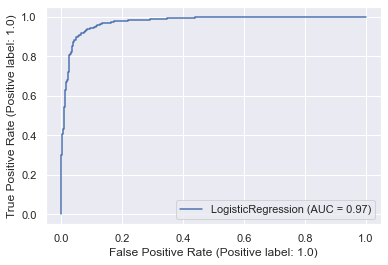

In [200]:
import seaborn as sns

sns.set()
metrics.plot_roc_curve(logistic_model, X_test, y_test)

In [201]:
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
fprs = np.array([])
tprs = np.array([])
y_pred_prob = logistic_model.predict_proba(X_test)
for threshold in thresholds:
    y_pred_threshold = np.array([1 if pred[1] >= threshold else 0 for pred in y_pred_prob])
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()
    fprs = np.append(fprs, fp/(fp + tn))
    tprs = np.append(tprs, tp/(tp + fn))

Text(0, 0.5, 'True Positive Rate')

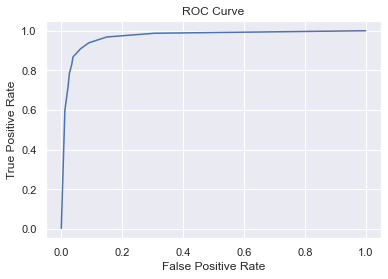

In [202]:
import matplotlib.pyplot as plt

plt.plot(fprs, tprs)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## Problem 4

In [203]:
def kfold_split(data: np.array, k: int):
    folds = []
    fold_size = int(data.shape[0]/k)
    for i in range(k):
        fold = data[i * fold_size: (i + 1) * fold_size]
        folds.append(fold)
    
    return np.array(folds)

In [204]:
def cross_validate(X: np.array, y: np.array, k: int, model):
    X_folds = kfold_split(X, k)
    y_folds = kfold_split(y, k)
    errors = np.array([])
    
    #running experiment i
    for i in range(k):
        X_testing_split = X_folds[i:i+1]
        X_testing_split = X_testing_split.reshape(-1, X_testing_split.shape[-1])
        
        X_training_split = np.append(X_folds[0:i], X_folds[i+1:k], axis=0)
        X_training_split = X_training_split.reshape(-1, X_training_split.shape[-1])
        
        y_testing_split = y_folds[i:i+1]
        y_testing_split = y_testing_split.flatten()
        
        y_training_split = np.append(y_folds[0:i], y_folds[i+1:k], axis=0)
        y_training_split = y_training_split.flatten()
        
        model_temp = clone(model)
        model_temp.fit(X_training_split, y_training_split)
        y_pred = model_temp.predict(X_testing_split)
        
        acc, _, _, _ = four_metrics(y_testing_split, y_pred)
        errors = np.append(errors, 1-acc)
    
    return errors.mean()

In [205]:
lda_model = LinearDiscriminantAnalysis()
logistic_model = LogisticRegression()

models = [lda_model, logistic_model]
model_names = ['LDA', 'Logistic']
k_vals = [5, 10]
df = pd.DataFrame(columns=['Model', 'k', 'Validation Error'])

for model, model_name in zip(models, model_names):
    for k in k_vals:
        error = cross_validate(X_train, y_train, k, model)
        df_new_row = pd.DataFrame.from_records([{'Model': model_name, 'k':k, 'Validation Error': error}])
        df = pd.concat([df, df_new_row], sort=False, ignore_index=True)


In [206]:
df

,Model,k,Validation Error
0,LDA,5,0.115652
1,LDA,10,0.114783
2,Logistic,5,0.078841
3,Logistic,10,0.077971
